In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with explicit reaction term that couples concentrations

import pyximport; pyximport.install()

from scipy.linalg import solve_banded
from olm.calcite import concCaEqFromPCO2, createPalmerInterpolationFunctions, palmerRate, calc_K_H,\
                        solutionFromCaPCO2, palmerFromSolution
from olm.general import CtoK



#define parameters for discretization
ntimes = 500
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
xmax = 1.
dx = xmax/(nx-1.)

#Dimensional parameters
L=1000.#m
D_w = 30.#m^2/s
D_a = 30.
Q_a = -1.#m^3/s
Q_w = 0.1#m^3/s
rho = 2.6#g/cm^3
g_mol_CaCO3 = 100.09
secs_per_year =  3.154e7
pCO2_0 = 5000.*1e-6 #5000 ppm converted to atm
pCO2_outside = 500.*1e-6
T_C=10.
T_K = CtoK(T_C)
K_H = calc_K_H(T_K) #Henry's law constant mols dissolved per atm
Ca_eq_0 = concCaEqFromPCO2(pCO2_0, T_C=T_C)
palmer_interp_funcs = createPalmerInterpolationFunctions(impure=True)

#Arrays of diameters, velocities, and Pe
D_H_w = ones(nx-1)
D_H_a = ones(nx-1)

P_w = D_H_w*np.pi/2.#assumes semi-circular xc
P_a = D_H_a*np.pi/2.

V_w = Q_w/(D_H_w/P_w/4.)#-1
V_a = Q_a/(D_H_a/P_a/4.)#0.1

#Time conversion parameter (between air and water)
T = V_w.mean()/np.abs(V_a.mean())
tau = L/V_w.mean()#Flowthrough time in secs
Pe_a = L*np.abs(V_a)/D_a
Pe_w = L*V_w/D_w

#Reaction/exchange parameters
Lambda_w = 0.5
Lambda_a = Lambda_w*T

#Construct A matrix
A_upper_air = dt*(np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1) 
A_lower_air = dt*(-np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1)
A_mid_air = (T+dt/(Pe_a*dx**2.))*ones(nx-1) 
A_upper_water = dt*(1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1) 
A_lower_water = dt*(-1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1)
A_mid_water = (1.+dt/(Pe_w*dx**2.))*ones(nx-1)

#A_upper = dt*(1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_lower = dt*(-1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_mid = (1.+dt/(Pe*dx**2.))*ones(nx-1)
A_upper_air[0] = 0.
A_lower_air[-1] = 0.
if V_a[0]>0:
    A_lower_air[-2] = -dt/(2.*dx)
    A_mid_air[-1] = T + dt/(2*dx)
else:
    A_upper_air[1] = -dt/(2.*dx)
    A_mid_air[0] = T + dt/(2*dx)
    
A_upper_water[0] = 0.
A_lower_water[-1] = 0.
A_lower_water[-2] = -dt/(2.*dx)
A_mid_water[-1] = 1. + dt/(2*dx)

A_air = vstack((A_upper_air, A_mid_air, A_lower_air))
A_water = vstack((A_upper_water, A_mid_water, A_lower_water))

#Create two concentration arrays
C_a = zeros([ntimes,nx])
C_w = zeros([ntimes,nx])
C_Ca = zeros([ntimes,nx])

#Set upstream boundary concentrations
C_a_upstream = pCO2_outside/pCO2_0
C_w_upstream = 1.
C_Ca_upstream = 0.5 #As percent of saturation at reference pCO2 (pCO2_0)

#Set initial conditions for both species
C_a[0,:] = C_a_upstream
C_w[0,:] = C_w_upstream
C_Ca[0,:] = C_Ca_upstream


if V_a[0]>0:
    C_a[:,0] = C_a_upstream
else:
    C_a[:,-1] = C_a_upstream

C_w[:,0] = C_w_upstream
C_Ca[:,0] = C_Ca_upstream

#Create b arrays for each concentration variable
bC_a = zeros(nx-1)
bC_w = zeros(nx-1)
bC_Ca = zeros(nx-1)

for n in arange(ntimes-1):
    print('Timestep=',n)
    #Calculate calcite dissolution rates in
    Ca_mol_L = Ca_eq_0*C_Ca[n,:]
    pCO2_atm = pCO2_0*C_w[n,:]
    sols = solutionFromCaPCO2(Ca_mol_L, pCO2_atm, T_C=T_C)
    print('done creating solutions')
#    Ca_eq_mol_L = concCaEqFromPCO2(pCO2_atm,T_C=T_C)
    #Calculate dissolution rate in mm/yr
#    F = palmerRate(T_C, pCO2_atm, Ca_mol_L/Ca_eq_mol_L, interp_funcs=palmer_interp_funcs)
    F = palmerFromSolution(sols, PCO2=pCO2_atm)
    print('done calculating palmer rates')
    mm_yr_to_mols_sec = 100.*rho/g_mol_CaCO3/secs_per_year/100./(D_H_w/2.)
    #Convert to mols/sec for conduit segment
    R = F[1:]*mm_yr_to_mols_sec
    #Convert to dimensionless Ca
    R_Ca = R*tau/Ca_eq_0
    #Convert to dimensionless pCO2
    R_CO2 = R*tau/K_H/pCO2_0
    
    #Calculate b matrix for C_a
    if V_a[0]>0:
        bC_a[0:-1] = C_a[n,1:-1]*(T-dt/(Pe_a[0:-1]*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a[0:-1])*dt/(4.*dx) + dt/(2.*Pe_a[0:-1]*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a[0:-1])*dt/(4.*dx) + dt/(2.*Pe_a[0:-1]*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[0] += dt*(1./(4.*dx) + 1./(2.*Pe_a[0]*dx**2.))*C_a_upstream
        bC_a[-1] = (T-dt/(2.*dx))*C_a[n,-1] + (dt/(2*dx))*C_a[n,-2] - dt*Lambda_a*(C_a[n,-1] - C_w[n,-1])#last term gets added to boundary cond.
    else:
        bC_a[1:] = C_a[n,1:-1]*(T-dt/(Pe_a[1:]*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a[1:])*dt/(4.*dx) + dt/(2.*Pe_a[1:]*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a[1:])*dt/(4.*dx) + dt/(2.*Pe_a[1:]*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[-1] += dt*(1./(4.*dx) + 1./(2.*Pe_a[-1]*dx**2.))*C_a_upstream
        bC_a[0] = (T-dt/(2.*dx))*C_a[n,0] + (dt/(2*dx))*C_a[n,1] - dt*Lambda_a*(C_a[n,0] - C_w[n,0])#last term gets added to boundary cond.

    #Calculate b matrix for C_w
    bC_w[0:-1] = C_w[n,1:-1]*(1.-dt/(Pe_w[0:-1]*dx**2.)) + C_w[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + C_w[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + dt*Lambda_w*(C_a[n,1:-1] - C_w[n,1:-1])\
                        - dt*R_CO2[0:-1]
    bC_w[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w[0]*dx**2.))*C_w_upstream
    bC_w[-1] = (1.-dt/(2.*dx))*C_w[n,-1] + (dt/(2*dx))*C_w[n,-2] + dt*Lambda_w*(C_a[n,-1] - C_w[n,-1]) - dt*R_CO2[-1]  

    #Calculate b matrix for C_Ca
    bC_Ca[0:-1] = C_Ca[n,1:-1]*(1.-dt/(Pe_w[0:-1]*dx**2.)) + C_Ca[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + C_Ca[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + dt*R_Ca[0:-1]
    bC_Ca[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w[0]*dx**2.))*C_Ca_upstream
    bC_Ca[-1] = (1.-dt/(2.*dx))*C_Ca[n,-1] + (dt/(2*dx))*C_Ca[n,-2] + dt*R_Ca[-1]  
    
    
    #Solve systems of equations
    if V_a[0]>0:
        C_a[n+1,1:] = solve_banded((1,1), A_air, bC_a)
    else:
        C_a[n+1,:-1] = solve_banded((1,1), A_air, bC_a)
   
    C_w[n+1,1:] = solve_banded((1,1), A_water, bC_w)
    C_Ca[n+1,1:] = solve_banded((1,1), A_water, bC_Ca)

Timestep= 0
done creating solutions
done calculating palmer rates
Timestep= 1
done creating solutions
done calculating palmer rates
Timestep= 2
done creating solutions
done calculating palmer rates
Timestep= 3
done creating solutions
done calculating palmer rates
Timestep= 4
done creating solutions
done calculating palmer rates
Timestep= 5
done creating solutions
done calculating palmer rates
Timestep= 6
done creating solutions
done calculating palmer rates
Timestep= 7
done creating solutions
done calculating palmer rates
Timestep= 8
done creating solutions
done calculating palmer rates
Timestep= 9
done creating solutions
done calculating palmer rates
Timestep= 10
done creating solutions
done calculating palmer rates
Timestep= 11
done creating solutions
done calculating palmer rates
Timestep= 12
done creating solutions
done calculating palmer rates
Timestep= 13
done creating solutions
done calculating palmer rates
Timestep= 14
done creating solutions
done calculating palmer rates
Times

KeyboardInterrupt: 

In [116]:
mm_yr_to_mols_sec.shape

(999,)

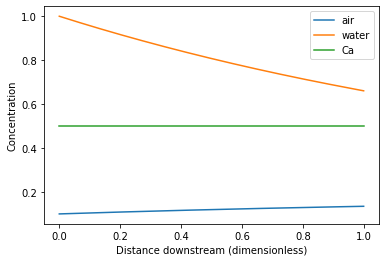

In [4]:
nx=1000
x = linspace(0,1,nx)
plot(x,C_a[936,:])
plot(x,C_w[936,:])
plot(x,C_Ca[936,:])
#plot(x,C_a[160,:])
#plot(x,C_w[160,:])
#plot(x,C_a[260,:])
#plot(x,C_w[260,:])
#plot(x,C_a[360,:])
#plot(x,C_w[360,:])

legend(['air','water', 'Ca'])
#Can compare against previous solution for D
#plot(x,D[200,:],'--')

xlabel('Distance downstream (dimensionless)')
ylabel('Concentration');

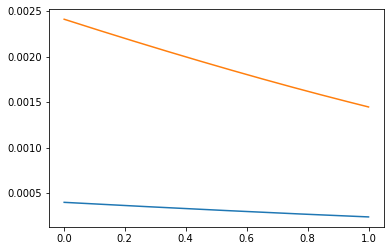

In [6]:
plot(x[1:],R_Ca)
plot(x[1:],R_CO2)
#plot(x,F)



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from CO2_transport_solver import calc_steady_adv_reaction

In [8]:
C_w, C_a, C_Ca, R = calc_steady_adv_reaction(1., 1., ntimes=1000,endtime=50.)

n= 0
rel tol C_w= 0.022522522496358444   abs_tol_C_w= 0.022522522496358444
rel tol C_a= 0.220769274274097   abs_tol_C_a= 0.0220769274274097
n= 1
rel tol C_w= 0.021968922545702502   abs_tol_C_w= 0.021474161594632002
rel tol C_a= 0.14404200496244918   abs_tol_C_a= 0.017584205386299498
n= 2
rel tol C_w= 0.021704551462210474   abs_tol_C_w= 0.020749693140562964
rel tol C_a= 0.05081931640589721   abs_tol_C_a= 0.007097483298065921
n= 3
rel tol C_w= 0.021684342316226367   abs_tol_C_w= 0.02028151629634556
rel tol C_a= 0.042542387983393964   abs_tol_C_a= 0.005853835337034846
n= 4
rel tol C_w= 0.021656479423654243   abs_tol_C_w= 0.01982045232158569
rel tol C_a= 0.031059741038289904   abs_tol_C_a= 0.004428413520738833
n= 5
rel tol C_w= 0.021509814255131147   abs_tol_C_w= 0.01926712779209483
rel tol C_a= 0.020903154974110306   abs_tol_C_a= 0.002558737114168236
n= 6
rel tol C_w= 0.02132638057358321   abs_tol_C_w= 0.018697175467067173
rel tol C_a= 0.02123517041296802   abs_tol_C_a= 0.0027819048590981

n= 137
rel tol C_w= 1.8247098410643184e-05   abs_tol_C_w= 1.823091248498443e-05
rel tol C_a= 0.00021651517922808625   abs_tol_C_a= 2.1673318180787104e-05
n= 138
rel tol C_w= 1.8113553447391087e-05   abs_tol_C_w= 1.809781620820683e-05
rel tol C_a= 0.0002150085979009453   abs_tol_C_a= 2.1517848405205875e-05
n= 139
rel tol C_w= 1.798229380176536e-05   abs_tol_C_w= 1.7966345162045982e-05
rel tol C_a= 0.00021342775901475288   abs_tol_C_a= 2.136423211489269e-05
n= 140
rel tol C_w= 1.7851981604264207e-05   abs_tol_C_w= 1.783646927433491e-05
rel tol C_a= 0.0002119565591875057   abs_tol_C_a= 2.121243594110922e-05
n= 141
rel tol C_w= 1.772387638386371e-05   abs_tol_C_w= 1.770815923851643e-05
rel tol C_a= 0.00021041306129842877   abs_tol_C_a= 2.106242733126984e-05
n= 142
rel tol C_w= 1.7596679223342835e-05   abs_tol_C_w= 1.758138647844909e-05
rel tol C_a= 0.00020897599116300285   abs_tol_C_a= 2.091417452342037e-05
n= 143
rel tol C_w= 1.7471614355629096e-05   abs_tol_C_w= 1.7456123125647593e-05
re

n= 299
rel tol C_w= 7.694812956355528e-06   abs_tol_C_w= 7.691404804388569e-06
rel tol C_a= 8.855928092657255e-05   abs_tol_C_a= 8.864275093917184e-06
n= 300
rel tol C_w= 7.67207950513232e-06   abs_tol_C_w= 7.668740431232557e-06
rel tol C_a= 8.817215997335834e-05   abs_tol_C_a= 8.82474492890084e-06
n= 301
rel tol C_w= 7.649586060342755e-06   abs_tol_C_w= 7.64619811344236e-06
rel tol C_a= 8.777193015660853e-05   abs_tol_C_a= 8.785462336902139e-06
n= 302
rel tol C_w= 7.627096489203638e-06   abs_tol_C_w= 7.623776821064077e-06
rel tol C_a= 8.738959578990463e-05   abs_tol_C_a= 8.746425121081147e-06
n= 303
rel tol C_w= 7.604843498695433e-06   abs_tol_C_w= 7.601475538465685e-06
rel tol C_a= 8.69943844084237e-05   abs_tol_C_a= 8.707631110577152e-06
n= 304
rel tol C_w= 7.582593729903193e-06   abs_tol_C_w= 7.579293262338638e-06
rel tol C_a= 8.661675280541532e-05   abs_tol_C_a= 8.669078160203347e-06
n= 305
rel tol C_w= 7.560577187534521e-06   abs_tol_C_w= 7.557228999255372e-06
rel tol C_a= 8.6226

n= 467
rel tol C_w= 5.057650156429017e-06   abs_tol_C_w= 5.0554167256855465e-06
rel tol C_a= 5.5275899317307474e-05   abs_tol_C_a= 5.530225805058797e-06
n= 468
rel tol C_w= 5.046759028018884e-06   abs_tol_C_w= 5.04455592020836e-06
rel tol C_a= 5.516063785038717e-05   abs_tol_C_a= 5.51838911125313e-06
n= 469
rel tol C_w= 5.035958051467271e-06   abs_tol_C_w= 5.033734254533684e-06
rel tol C_a= 5.5039708547418755e-05   abs_tol_C_a= 5.506594813645127e-06
n= 470
rel tol C_w= 5.025145238650033e-06   abs_tol_C_w= 5.022951511723939e-06
rel tol C_a= 5.492526629669415e-05   abs_tol_C_a= 5.494842681474932e-06
n= 471
rel tol C_w= 5.014421713161313e-06   abs_tol_C_w= 5.012207480392661e-06
rel tol C_a= 5.4805203505845084e-05   abs_tol_C_a= 5.483132485634146e-06
n= 472
rel tol C_w= 5.003686362300813e-06   abs_tol_C_w= 5.001501949486453e-06
rel tol C_a= 5.469157160720041e-05   abs_tol_C_a= 5.471463998693582e-06
n= 473
rel tol C_w= 4.99303944677019e-06   abs_tol_C_w= 4.9908347092841865e-06
rel tol C_a= 

n= 637
rel tol C_w= 3.6414190781446965e-06   abs_tol_C_w= 3.6398136288307015e-06
rel tol C_a= 3.983455782664384e-05   abs_tol_C_a= 3.985324504920951e-06
n= 638
rel tol C_w= 3.63503742933177e-06   abs_tol_C_w= 3.633448024453756e-06
rel tol C_a= 3.976661336936784e-05   abs_tol_C_a= 3.978368388918296e-06
n= 639
rel tol C_w= 3.628699768730814e-06   abs_tol_C_w= 3.6270999502763246e-06
rel tol C_a= 3.96956942168367e-05   abs_tol_C_a= 3.971431353430588e-06
n= 640
rel tol C_w= 3.62235321777594e-06   abs_tol_C_w= 3.62076933602129e-06
rel tol C_a= 3.9628119392208225e-05   abs_tol_C_a= 3.964513321005891e-06
n= 641
rel tol C_w= 3.616050328655185e-06   abs_tol_C_w= 3.614456109968245e-06
rel tol C_a= 3.955759034288836e-05   abs_tol_C_a= 3.957614214594729e-06
n= 642
rel tol C_w= 3.6097385907219617e-06   abs_tol_C_w= 3.608160201951094e-06
rel tol C_a= 3.949038216913015e-05   abs_tol_C_a= 3.950733957577834e-06
n= 643
rel tol C_w= 3.603470190228867e-06   abs_tol_C_w= 3.6018815404714744e-06
rel tol C_a= 

n= 803
rel tol C_w= 2.7807409245315404e-06   abs_tol_C_w= 2.7795161334775997e-06
rel tol C_a= 3.0431380241647665e-05   abs_tol_C_a= 3.0445512912702366e-06
n= 804
rel tol C_w= 2.7765266695606334e-06   abs_tol_C_w= 2.7753114520967515e-06
rel tol C_a= 3.038631460907482e-05   abs_tol_C_a= 3.039950122421531e-06
n= 805
rel tol C_w= 2.7723373957671937e-06   abs_tol_C_w= 2.7711163177457365e-06
rel tol C_a= 3.033950510611775e-05   abs_tol_C_a= 3.035359371336699e-06
n= 806
rel tol C_w= 2.768142257098378e-06   abs_tol_C_w= 2.7669306976729757e-06
rel tol C_a= 3.0294641816403773e-05   abs_tol_C_a= 3.0307790039457716e-06
n= 807
rel tol C_w= 2.7639719418973504e-06   abs_tol_C_w= 2.7627545600150683e-06
rel tol C_a= 3.024804511250435e-05   abs_tol_C_a= 3.0262089863453134e-06
n= 808
rel tol C_w= 2.7597957930025925e-06   abs_tol_C_w= 2.7585878751290593e-06
rel tol C_a= 3.0203382851099695e-05   abs_tol_C_a= 3.0216492847012777e-06
n= 809
rel tol C_w= 2.755644315898306e-06   abs_tol_C_w= 2.7544306133719942e

n= 958
rel tol C_w= 2.2263644033407407e-06   abs_tol_C_w= 2.225389365562158e-06
rel tol C_a= 2.436865866073426e-05   abs_tol_C_a= 2.4379307249910998e-06
n= 959
rel tol C_w= 2.2233384138945907e-06   abs_tol_C_w= 2.2223597535564465e-06
rel tol C_a= 2.4334901227843263e-05   abs_tol_C_a= 2.43461283337687e-06
n= 960
rel tol C_w= 2.220308502318048e-06   abs_tol_C_w= 2.219336109998693e-06
rel tol C_a= 2.430239420708392e-05   abs_tol_C_a= 2.4313014646420994e-06
n= 961
rel tol C_w= 2.2172944115552878e-06   abs_tol_C_w= 2.2163184183465745e-06
rel tol C_a= 2.4268770214411495e-05   abs_tol_C_a= 2.4279966006623965e-06
n= 962
rel tol C_w= 2.2142764181753463e-06   abs_tol_C_w= 2.213306660947545e-06
rel tol C_a= 2.4236389837106223e-05   abs_tol_C_a= 2.4246982232717373e-06
n= 963
rel tol C_w= 2.2112741582991203e-06   abs_tol_C_w= 2.2103008217033704e-06
rel tol C_a= 2.4202898539329702e-05   abs_tol_C_a= 2.4214063144983866e-06
n= 964
rel tol C_w= 2.208268016739513e-06   abs_tol_C_w= 2.2073008842937725e-0

UnboundLocalError: local variable 'R' referenced before assignment

In [8]:
max([C_w,C_a])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
C_Ca[942,-10:]

array([0.50031472, 0.50031497, 0.50031522, 0.50031546, 0.50031571,
       0.50031596, 0.50031621, 0.50031646, 0.50031671, 0.50031696])